# Integrate Asger's heads

In [81]:
from itertools import chain

import torch
from torch import nn as nn
import torchvision

# from mini_trainer.classifier import Classifier
from mini_trainer.hierarchical.integration import sparse_masks_from_labels, HierarchicalBuilder
from mini_trainer.hierarchical.model import HierarchicalClassifier
from mini_trainer.hierarchical.loss import MultiLevelWeightedCrossEntropyLoss, MultiLevelLoss

from pathlib import Path
import pandas as pd
from collections import OrderedDict
import yaml

from fastai.learner import Learner
from fastai.vision.all import (
    DataBlock,
    ImageBlock,
    MultiCategoryBlock,
    CategoryBlock,
    ColSplitter,
    ColReader,
    Pipeline,
    Resize,
    aug_transforms,
    vision_learner,
    # partial,
    # F1ScoreMulti,
    # accuracy_multi,
    # ShowGraphCallback,
    # CSVLogger,
    # EarlyStoppingCallback,
    # ImageDataLoaders,
    # SaveModelCallback,
    DisplayedTransform,
)
# from fastai.transform import Transform

from time import time

In [2]:
hier_path = Path("/home/george/codes/lepinet/data/global_lepi/hierarchy.csv")

In [3]:
hier = pd.read_csv(hier_path)
labels = {str(r['speciesKey']):r.values.astype(str).tolist() for i,r in hier.iterrows()}
cls2idx = {str(i):{str(e):j for j,e in enumerate(s.unique())} for i,(n,s) in enumerate(hier.items())}

In [4]:
sparse_masks=sparse_masks_from_labels(labels, cls2idx)

In [85]:
# model
model_builder_kwargs ={
            "model_type" : "efficientnet_v2_s",
            "weights" : None,
            "hidden" : 512,
            "droprate" : 0.1,
            "normalized" : True,
            "sparse_masks" : sparse_masks,
            "num_classes" : len(cls2idx['0']),
        }
model, model_preprocessor = HierarchicalClassifier.build(**model_builder_kwargs)

In [77]:
# loss function
class SumMultiLevelWeightedCrossEntropyLoss(torch.nn.modules.loss._Loss):
    def __init__(
            self, 
            weights : list[float | int] | torch.Tensor,
            device : torch._prims_common.DeviceLikeType, 
            dtype : torch.types._dtype, 
            class_weights : list[torch.Tensor] | None=None,
            label_smoothing : float = 0.0
        ):
        super().__init__()
        self.device = device
        self.dtype = dtype

        self.weights = torch.tensor(weights).to(device=device, dtype=dtype)
        self.n_levels = len(weights)
        self.label_smoothing = [1 - (1 - label_smoothing)**(1/(i+1)) for i in range(self.n_levels)]
        
        self._loss_fns = [
            nn.CrossEntropyLoss(
                # weight=None, #self.class_weights[i], 
                # reduction="none", 
                label_smoothing=label_smoothing
            ) for _ in range(self.n_levels)
        ]

    def __call__(
            self, 
            preds : torch.Tensor, 
            *targets
        ) -> "MultiLevelLoss":
        return sum(list(MultiLevelLoss(
            [
                self._loss_fns[i](preds[i], targets[i])
                for i in range(self.n_levels)
            ], 
             self.weights
        )))
loss = SumMultiLevelWeightedCrossEntropyLoss(weights=[1.0,1.0,1,0], device='cpu', dtype=torch.float)

In [7]:
config_path = Path("/home/george/codes/lepinet/configs/20251106_1_test_ece.yaml")
with open(config_path) as f:
    config=yaml.safe_load(f)
# gen_dls = getattr(importlib.import_module('011_lepi_large_prod_v2'), 'gen_dls')
# dls,hierarchy=gen_dls(**config['train'])
# model_arch = getattr(importlib.import_module('fastai.vision.all'), config['train']['model_arch_name'])
# learn = vision_learner(dls, model_arch)
# learn.model

In [7]:
df_path = Path("/home/george/codes/lepinet/data/global_lepi/0032836-250426092105405_processing_metadata_postprocessed_quality_filtered.lepinet.parquet")
df = pd.read_parquet(df_path)

In [9]:
df.head()

,image_path,hierarchy_labels,is_valid
0,5137706/75f3ff7be2d56cb3307edb8c67d732e2266a13d0.jpg,5137706 7786896 5481,True
1,8049830/b2bf0453bd8d373dab0bb4f9500c1cfb7e7facce.jpg,8049830 1894469 7017,False
2,7728366/2acc7185dc309dfef4c157491028ea5f2dc8a02e.jpg,7728366 1911078 7017,False
3,1808752/aacd8c076272c1954b27d230936b28aa19509691.jpg,1808752 1808720 4532185,False
4,1864652/338cb27a67d8822799c3671764ce9bf081c18f87.jpg,1864652 1864584 8868,True


In [50]:
i,r=next(iter(df.iterrows()))

In [58]:
r['speciesKey'], r['genusKey'], r['familyKey']

('5137706', '7786896', '5481')

In [14]:
aug_img_size = 460
img_size = 256
batch_size = 64

img_dir = Path("/home/george/codes/lepinet/data/global_lepi/images")
vocab=[]
for c in hier.columns: vocab.extend(hier[c].unique().astype(str).tolist())

In [11]:
start = time()
datablock = DataBlock(
        blocks=(ImageBlock, MultiCategoryBlock(vocab=vocab)),
        splitter=ColSplitter(),
        get_x=ColReader(0, pref=img_dir),
        get_y=ColReader(1, label_delim=' '),
        item_tfms=Resize(aug_img_size),
        batch_tfms=aug_transforms(size=img_size)
    )
dls = datablock.dataloaders(df, bs=batch_size)
end = time()
print(end-start)

19.678452491760254


In [10]:
df[['speciesKey','genusKey','familyKey']] = df['hierarchy_labels'].str.split(' ', expand=True)

In [11]:
df.head()

,image_path,hierarchy_labels,is_valid,speciesKey,genusKey,familyKey
0,5137706/75f3ff7be2d56cb3307edb8c67d732e2266a13d0.jpg,5137706 7786896 5481,True,5137706,7786896,5481
1,8049830/b2bf0453bd8d373dab0bb4f9500c1cfb7e7facce.jpg,8049830 1894469 7017,False,8049830,1894469,7017
2,7728366/2acc7185dc309dfef4c157491028ea5f2dc8a02e.jpg,7728366 1911078 7017,False,7728366,1911078,7017
3,1808752/aacd8c076272c1954b27d230936b28aa19509691.jpg,1808752 1808720 4532185,False,1808752,1808720,4532185
4,1864652/338cb27a67d8822799c3671764ce9bf081c18f87.jpg,1864652 1864584 8868,True,1864652,1864584,8868


In [12]:
vocab_3 = df['speciesKey'].unique().tolist()
vocab_4 = df['genusKey'].unique().tolist()
vocab_5 = df['familyKey'].unique().tolist()

In [88]:
model_preprocessor.

functools.partial(<function preprocess at 0x7f9dbb825f80>, transform=ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
), func=ToDtype(scale=True))

In [87]:
start = time()
datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock(vocab=vocab_3), CategoryBlock(vocab=vocab_4), CategoryBlock(vocab=vocab_5)),
    n_inp=1,
    splitter=ColSplitter(),
    get_x=ColReader(0, pref=img_dir),
    get_y=[ColReader(3), ColReader(4), ColReader(5)],
    item_tfms=[Resize(aug_img_size), model_preprocessor],
    batch_tfms=aug_transforms(size=img_size)
)
dls = datablock.dataloaders(df, bs=4)
end = time()
print(end-start)

Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:


TypeError: 'item' must be of type `str` or `torch.Tensor`, not <class 'fastai.vision.core.PILImage'>

In [ ]:
b=dls.train.one_batch()

In [34]:
b[-1].tensor()

AttributeError: 'TensorCategory' object has no attribute 'tensor'

In [21]:
b[0].shape

torch.Size([64, 3, 256, 256])

In [42]:
b[1].data

TensorCategory([ 5750,  1387,  8995,  7294,   870,  8649,  8960,  5187,  5403,
                 2525,  3350,  9079,  5983, 10745,  2514,  6099,  6621,  8426,
                 2983,  3673,  4516,  2771,  6018, 10194,  7392,  7392, 10498,
                10922,  5257, 10705, 10947,  2339,  5042,  9083,  7355,  7589,
                 9573,  8037, 11121,  8236,  8243, 10295, 10400,  6079,   777,
                10551,  3090,  4820,  6422,  6528,  8883, 10297,  8882,  6226,
                 7758,  5465,  2494,  5886,  2731,  2396, 10729,  8216,  5278,
                11135], device='cuda:0')

In [18]:
out=model(model_preprocessor(b[0].cpu()))

In [19]:
len(out)

3

In [38]:
out[0].shape

torch.Size([64, 11939])

In [39]:
b[1].shape

torch.Size([64])

In [37]:
[type(i) for i in out]

[fastai.torch_core.TensorImage,
 fastai.torch_core.TensorImage,
 fastai.torch_core.TensorImage]

In [36]:
[type(i) for i in list(b[1:])]

[fastai.torch_core.TensorCategory,
 fastai.torch_core.TensorCategory,
 fastai.torch_core.TensorCategory]

In [35]:
loss(out,list(b[1:]))

TypeError: no implementation found for 'torch.nn.functional.cross_entropy' on types that implement __torch_function__: [<class 'fastai.torch_core.TensorImage'>, <class 'fastai.torch_core.TensorCategory'>]

In [61]:
type(SumMultiLevelWeightedCrossEntropyLoss(weights=[1.0,1.0,1,0], device='cpu', dtype=torch.float))

__main__.SumMultiLevelWeightedCrossEntropyLoss

In [92]:
learn = Learner(
    dls,
    model,
    loss_func=SumMultiLevelWeightedCrossEntropyLoss(weights=[1.0,0.0,0.0], device='cuda', dtype=torch.float),
)

SuggestedLRs(valley=0.0005754399462603033)

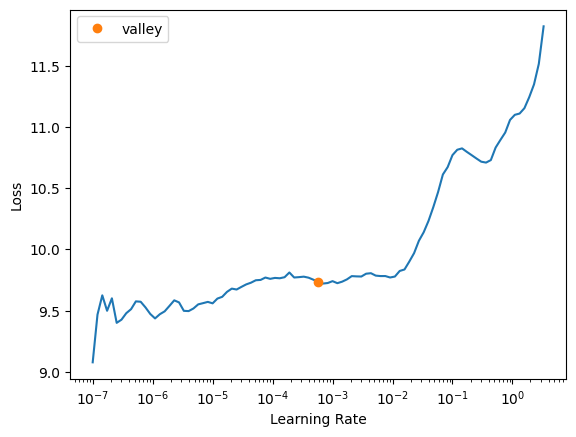

In [93]:
learn.lr_find()

In [79]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,time


KeyboardInterrupt: 